In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 1100

ng =5

ng_refs = (/ 5 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 500 /) 

t_refs = (/ 250 /) 

tsfc =294

vstar = 1900

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.4 , 0.4 , 0.5 , 0.6,
     &     0.9/

atmosphere_profiles/mls75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

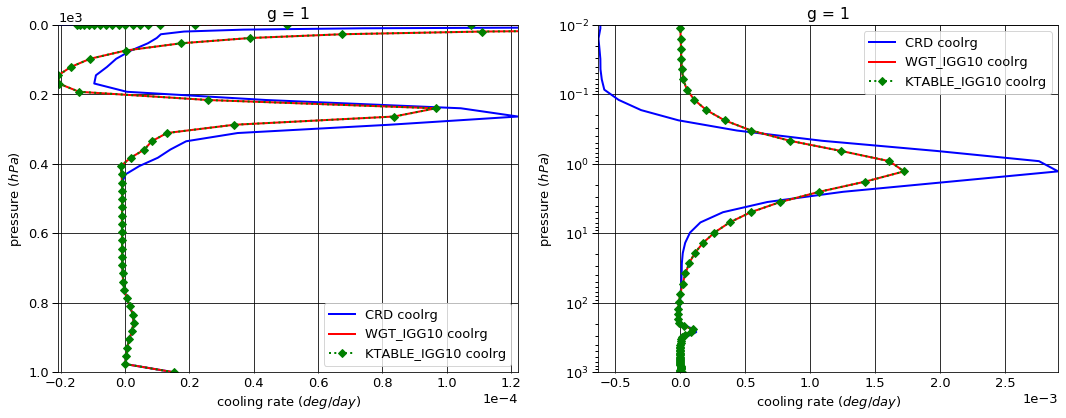

# Figure: cooling rate g-group 2

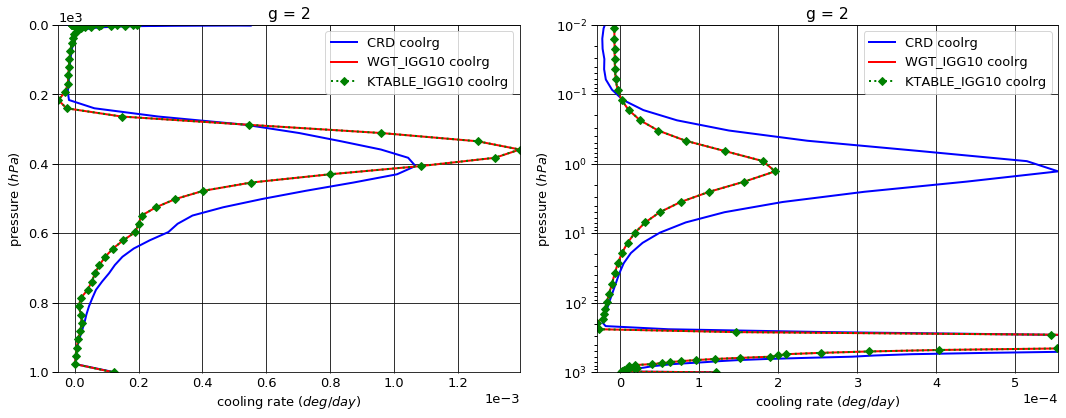

# Figure: cooling rate g-group 3

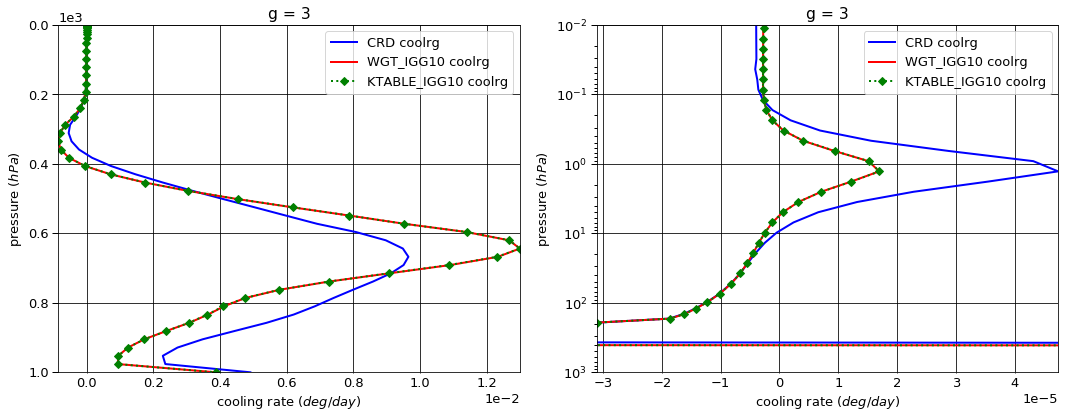

# Figure: cooling rate g-group 4

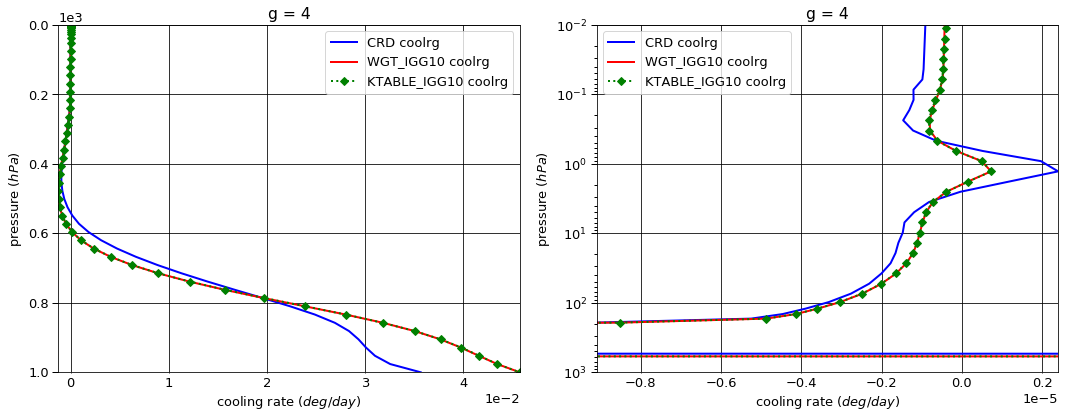

# Figure: cooling rate g-group 5

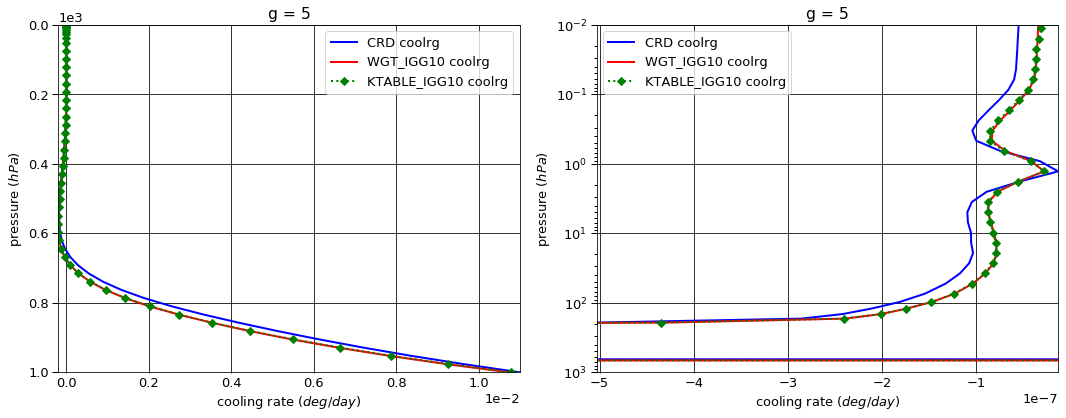

# Figure: cooling rate g-group total

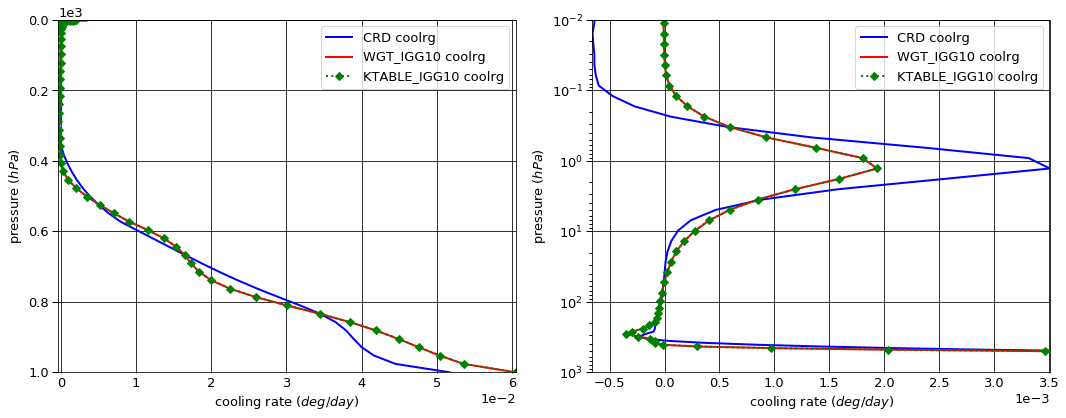

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.002140  0.000000 -0.002140
  1013.0   76    -0.030201  0.030158 -0.000043
2 0.0      1     -0.032385  0.000000 -0.032385
  1013.0   76    -0.237184  0.236832 -0.000352
3 0.0      1     -0.426608  0.000000 -0.426608
  1013.0   76    -1.113830  1.095184 -0.018646
4 0.0      1     -1.687125  0.000000 -1.687125
  1013.0   76    -2.234557  1.509433 -0.725124
5 0.0      1     -2.948881  0.000000 -2.948881
  1013.0   76    -3.009679  0.231892 -2.777787


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001790  0.000000 -0.001790
  1013.0   76    -0.030201  0.030158 -0.000043
2 0.0      1     -0.029317  0.000000 -0.029317
  1013.0   76    -0.237184  0.236842 -0.000342
3 0.0      1     -0.400126  0.000000 -0.400126
  1013.0   76    -1.113830  1.103168 -0.010662
4 0.0      1     -1.709736  0.000000 -1.709736
  1013.0   76    -2.234557  1.612621 -0.621936
5 0.0      1     -2.955677  0.000000 -2.955677
  1013.0   76    -3.009679  0.205786 -2.803894


KTABLE_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001790  0.000000 -0.001790
  1013.0   76    -0.030201  0.030158 -0.000043
2 0.0      1     -0.029310  0.000000 -0.029310
  1013.0   76    -0.237184  0.236842 -0.000342
3 0.0      1     -0.399832  0.000000 -0.399832
  1013.0   76    -1.113830  1.103182 -0.010648
4 0.0      1     -1.708731  0.000000 -1.708731
  1013.0   76    -2.234557  1.614489 -0.620068
5 0.0      1     -2.955359  0.000000 -2.955359
  1013.0   76    -3.009679  0.206862 -2.802817


WGT_IGG10 - CRD


flug          fldg     fnetg
g pressure level                                      
1 0.0      1      3.501269e-04  0.000000e+00  0.000350
  1013.0   76     0.000000e+00  3.469447e-18  0.000000
2 0.0      1      3.067855e-03  0.000000e+00  0.003068
  1013.0   76     0.000000e+00  1.036000e-05  0.000010
3 0.0      1      2.648172e-02  0.000000e+00  0.026482
  1013.0   76     0.000000e+00  7.984500e-03  0.007984
4 0.0      1     -2.261140e-02  0.000000e+00 -0.022611
  1013.0   76    -4.440892e-16  1.031874e-01  0.103187
5 0.0      1     -6.795800e-03  0.000000e+00 -0.006796
  1013.0   76     0.000000e+00 -2.610675e-02 -0.026107


KTABLE_IGG10 - CRD


flug          fldg     fnetg
g pressure level                                      
1 0.0      1      3.500632e-04  0.000000e+00  0.000350
  1013.0   76     0.000000e+00  3.469447e-18  0.000000
2 0.0      1      3.075532e-03  0.000000e+00  0.003076
  1013.0   76     0.000000e+00  1.036000e-05  0.000010
3 0.0      1      2.677636e-02  0.000000e+00  0.026776
  1013.0   76     0.000000e+00  7.998000e-03  0.007998
4 0.0      1     -2.160590e-02  0.000000e+00 -0.021606
  1013.0   76    -4.440892e-16  1.050555e-01  0.105055
5 0.0      1     -6.478100e-03  0.000000e+00 -0.006478
  1013.0   76     0.000000e+00 -2.502996e-02 -0.025030

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -6.473290e-04
  1001.112500 75     1.530046e-05
2 0.000312    1     -2.568055e-05
  1001.112500 75     1.251864e-04
3 0.000312    1     -3.982358e-06
  1001.112500 75     4.911537e-03
4 0.000312    1     -8.321589e-07
  1001.112500 75     3.566845e-02
5 0.000312    1     -5.056032e-08
  1001.112500 75     1.099462e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.496688e-05
  1001.112500 75     1.530046e-05
2 0.000312    1     -8.165115e-06
  1001.112500 75     1.213346e-04
3 0.000312    1     -2.670049e-06
  1001.112500 75     3.873042e-03
4 0.000312    1     -3.744322e-07
  1001.112500 75     4.576262e-02
5 0.000312    1     -2.968415e-08
  1001.112500 75     1.073425e-02


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.474658e-05
  1001.112500 75     1.530046e-05
2 0.000312    1     -7.588852e-06
  1001.112500 75     1.213346e-04
3 0.000312    1     -2.313937e-06
  1001.112500 75     3.867654e-03
4 0.000312    1     -2.234027e-07
  1001.112500 75     4.573216e-02
5 0.000312    1     -1.832444e-08
  1001.112500 75     1.077459e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      6.323622e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      1.751544e-05
  1001.112500 75    -3.851840e-06
3 0.000312    1      1.312309e-06
  1001.112500 75    -1.038494e-03
4 0.000312    1      4.577267e-07
  1001.112500 75     1.009417e-02
5 0.000312    1      2.087617e-08
  1001.112500 75    -2.603660e-04


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      6.325825e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      1.809170e-05
  1001.112500 75    -3.851840e-06
3 0.000312    1      1.668421e-06
  1001.112500 75    -1.043883e-03
4 0.000312    1      6.087563e-07
  1001.112500 75     1.006371e-02
5 0.000312    1      3.223588e-08
  1001.112500 75    -2.200230e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.097139,0.0000,-5.097139
1013.0,76,-6.625452,3.1035,-3.521952



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.096647,0.000000,-5.096647
1013.0,76,-6.625452,3.188576,-3.436877



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.095021,0.000000,-5.095021
1013.0,76,-6.625452,3.191534,-3.433918



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.000493,0.000000,0.000493
1013.0,76,0.000000,0.085076,0.085075



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.002118,0.000000,0.002118
1013.0,76,0.000000,0.088034,0.088034


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000678
1001.112500,75,0.051715



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000026
1001.112500,75,0.060507



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000025
1001.112500,75,0.060511



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000652
1001.112500,75,0.008791



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000653
1001.112500,75,0.008796


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001336,0.005408
2,0.011914,0.041776
3,0.068623,0.194239
4,0.253773,0.361773
5,0.664355,0.396805


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.335911e-20
2,5.630332e-22
3,2.372961e-23
4,1.000109e-24
5,6.466739e-29


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.335911e-20,NaN,0.001336,0.005408,0.001336,0.005408,500.0
2,5.630332e-22,0.042146,0.011914,0.041776,0.013250,0.047184,500.0
3,2.372961e-23,0.042146,0.068623,0.194239,0.081873,0.241423,500.0
4,1.000109e-24,0.042146,0.253773,0.361773,0.335645,0.603195,500.0
5,6.466739e-29,0.000065,0.664355,0.396805,1.000000,1.000000,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog        ratio        taulyr
layer g pressure                                                          
1     1 0.000312     4.287430e-20  1.634008e-21    26.238741  1.543982e-06
      2 0.000312     5.380318e-22  1.573968e-23    34.183137  1.913201e-08
      3 0.000312     7.531416e-24  3.917037e-25    19.227329  3.373710e-10
      4 0.000312     1.877930e-25  1.915708e-26     9.802798  1.024818e-11
      5 0.000312     5.981584e-27  4.800100e-30  1246.137300  4.584995e-13
2     1 0.000750     4.299886e-20  1.635844e-21    26.285427  6.236423e-07
      2 0.000750     5.397832e-22  1.577151e-23    34.225208  7.730803e-09
      3 0.000750     7.562221e-24  3.928994e-25    19.247217  1.364374e-10
      4 0.000750     1.893486e-25  1.925025e-26     9.836159  4.161122e-12
      5 0.000750     6.027019e-27  4.920652e-30  1224.841600  1.860806e-13
3     1 0.001052     4.326363e-20  1.639499e-21    26.388324  8.797871e-07
      2 0.001052     5.435168e-22  1.583306e-23    34.327977  1.091519e-08
      3 0.001052     7.628070e-24  3.953039e-25    19.296724  1.929794e-10
      4 0.001052     1.926908e-25  1.944194e-26     9.911090  5.935653e-12
      5 0.001052     6.124713e-27  5.029450e-30  1217.769900  2.651868e-13
4     1 0.001476     4.354458e-20  1.643421e-21    26.496294  1.241989e-06
      2 0.001476     5.474997e-22  1.589924e-23    34.435595  1.542302e-08
      3 0.001476     7.698646e-24  3.978901e-25    19.348675  2.731980e-10
      4 0.001476     1.962992e-25  1.964715e-26     9.991227  8.478726e-12
      5 0.001476     6.230253e-27  5.171498e-30  1204.728900  3.784396e-13
5     1 0.002070     4.382646e-20  1.647429e-21    26.602942  1.752898e-06
      2 0.002070     5.515179e-22  1.596717e-23    34.540736  2.178812e-08
      3 0.002070     7.770203e-24  4.005360e-25    19.399512  3.866958e-10
      4 0.002070     1.999850e-25  1.985565e-26    10.071945  1.210937e-11
      5 0.002070     6.338133e-27  5.357608e-30  1183.015400  5.399863e-13
6     1 0.002904     4.410903e-20  1.651550e-21    26.707662  2.474191e-06
      2 0.002904     5.555685e-22  1.603751e-23    34.641809  3.078375e-08
      3 0.002904     7.842700e-24  4.032569e-25    19.448397  5.474263e-10
      4 0.002904     2.037471e-25  2.006808e-26    10.152797  1.729726e-11
      5 0.002904     6.448321e-27  5.605737e-30  1150.307300  7.706295e-13
7     1 0.004074     4.439228e-20  1.655824e-21    26.809780  3.492310e-06
      2 0.004074     5.596523e-22  1.611126e-23    34.736712  4.349511e-08
      3 0.004074     7.916168e-24  4.060765e-25    19.494278  7.750194e-10
      4 0.004074     2.075879e-25  2.028559e-26    10.233269  2.470956e-11
      5 0.004074     6.560891e-27  5.939469e-30  1104.625700  1.099895e-12
8     1 0.005714     4.467621e-20  1.660312e-21    26.908330  4.928968e-06
      2 0.005714     5.637702e-22  1.618978e-23    34.822594  6.145237e-08
      3 0.005714     7.990643e-24  4.090287e-25    19.535656  1.097218e-09
      4 0.005714     2.115102e-25  2.050983e-26    10.312624  3.529786e-11
      5 0.005714     6.675927e-27  6.391293e-30  1044.534700  1.569860e-12
9     1 0.008015     4.496089e-20  1.665096e-21    27.001980  6.956719e-06
      2 0.008015     5.679244e-22  1.627504e-23    34.895432  8.682782e-08
      3 0.008015     8.066187e-24  4.121618e-25    19.570437  1.553501e-09
      4 0.008015     2.155179e-25  2.074316e-26    10.389831  5.042825e-11
      5 0.008015     6.793550e-27  7.005360e-30   969.764630  2.240883e-12
10    1 0.011243     4.524629e-20  1.670294e-21    27.088819  9.818437e-06
      2 0.011243     5.721159e-22  1.636975e-23    34.949582  1.226840e-07
      3 0.011243     8.142846e-24  4.155431e-25    19.595674  2.199659e-09
      4 0.011243     2.196146e-25  2.098885e-26    10.463396  7.204946e-11
      5 0.011243     6.913862e-27  7.840258e-30   881.841060  3.198977e-12
11    1 0.015771     4.553238e-20  1.676068e-21    27.166189  1.385750e-05
      2 0.015771     5.763465e-22  1.647775e-23    

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
